In [13]:
# Import necessary libraries
import requests
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("MonsterDamageStream").getOrCreate()



In [14]:


# Define the schema
schema = StructType([
    StructField("country", StringType(), True),
    StructField("population", LongType(), True),
    StructField("monster_name", StringType(), True),
    StructField("damage", LongType(), True),
    StructField("updated_population", LongType(), True),
    StructField("percent_loss", DoubleType(), True),
    StructField("ts", StringType(), True)
])

# Initialize an empty DataFrame with the schema
df = spark.createDataFrame([], schema=schema)

In [15]:
# Define a function to update the DataFrame
def update_df():
    global df
    response = requests.get('http://18.133.251.249:5000/get_messages')
    messages = response.json()
    new_data = [eval(message) for message in messages]
    # Assuming you've already converted the raw data to a DataFrame
    new_df = spark.createDataFrame(new_data)

    # Apply the transformation
    new_df = new_df.withColumn("percent_loss", 
                            when(col("percent_loss") == 100, col("percent_loss").cast(DoubleType()))
                            .otherwise(col("percent_loss")))

    
    df = df.union(new_df)
    
    return df

ConnectionError: HTTPConnectionPool(host='18.133.251.249', port=5000): Max retries exceeded with url: /get_messages (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x15c971690>: Failed to establish a new connection: [Errno 61] Connection refused'))

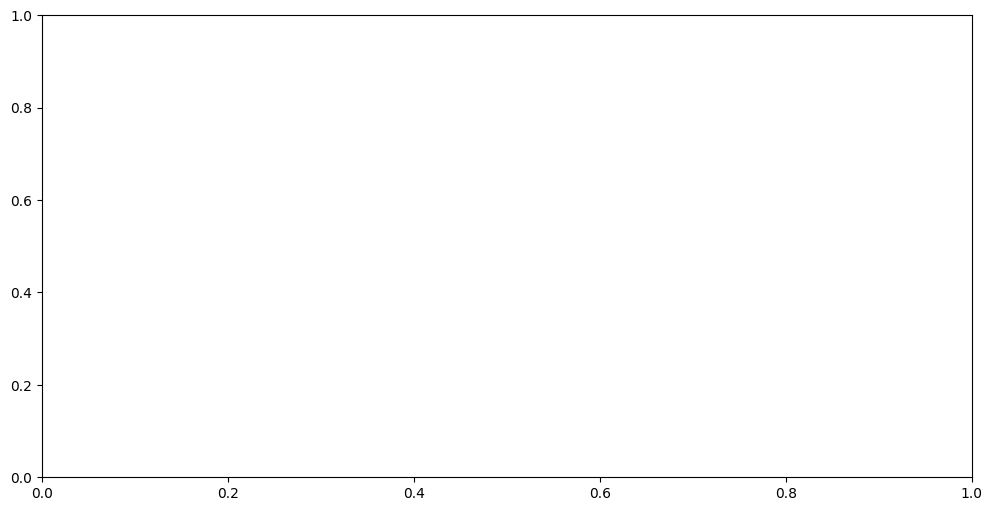

23/10/07 20:01:51 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1040843 ms exceeds timeout 120000 ms
23/10/07 20:01:51 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/07 20:17:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [16]:
import numpy as np  # Ensure numpy is imported
from IPython.display import display, clear_output

# Create initial plot
fig, ax = plt.subplots(figsize=(12,6))

# Continuously update
while True:
    # Update data
    df = update_df()
    
    # Convert to pandas for visualization
    pdf = df.groupBy("country").agg({"damage": "sum"}).toPandas()
    pdf = pdf.sort_values("sum(damage)", ascending=False)
    
    # Clear previous plot data
    ax.clear()
    
    # Plotting
    ax.bar(pdf["country"], pdf["sum(damage)"])
    ax.set_title("Total Damage by Country")
    ax.set_xlabel("Country")
    ax.set_ylabel("Damage")
    
    y_max = pdf["sum(damage)"].max() + 10000  # Added buffer for y-axis
    y_ticks_interval = 50000
    ax.set_yticks(np.arange(0, y_max, step=y_ticks_interval))  # Yticks based on damage
    
    plt.xticks(rotation=45)
    
    # Display the plot
    clear_output(wait=True)  # Clear previous plot
    display(fig)  # Display current plot
    time.sleep(10)


In [ ]:
from IPython.display import display, clear_output

# Create initial plot
fig, ax = plt.subplots(figsize=(12,6))

# Continuously update
while True:
    # Update data
    df = update_df()
    
    # Convert to pandas for visualization
    pdf = df.groupBy("country").agg({"damage": "sum"}).toPandas()
    pdf = pdf.sort_values("sum(damage)", ascending=False)
    
    # Clear previous plot data
    ax.clear()
    
    # Plotting
    ax.bar(pdf["country"], pdf["sum(damage)"])
    ax.set_title("Total Damage by Country")
    ax.set_xlabel("Country")
    ax.set_ylabel("Damage")
    
    y_max = pdf["sum(damage)"].max()
    y_ticks_interval = y_max // 10  # Divide by 10 to get 10 intervals
    
    ax.set_yticks(np.arange(0, y_max + y_ticks_interval, step=y_ticks_interval))  # Yticks based on damage
    
    plt.xticks(rotation=45)
    
    # Display the plot
    clear_output(wait=True)  # Clear previous plot
    display(fig)  # Display current plot
    time.sleep(10)
